<a href="https://colab.research.google.com/github/Debora-Simoes/IA901-2023S1/blob/main/projetos/Reconhecimento_acao_humana_imagem_drone/notebooks/Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import shutil

#import matplotlib.image as mpimg
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Importando dados brutos

In [ ]:
TRAIN_DATA_DIR = "/content/gdrive/My Drive/IA901_Projeto/_Dataset_NTUT_4K_drone/ntut_drone_train/ntut_drone_train"
TEST_DATA_DIR = '/content/gdrive/My Drive/IA901_Projeto/_Dataset_NTUT_4K_drone/ntut_drone_test/ntut_drone_test'

In [ ]:
lista_de_drones = os.listdir(TRAIN_DATA_DIR)
lista_de_drones

['Drone_023', 'Drone_005', 'Drone_031', 'Drone_049']

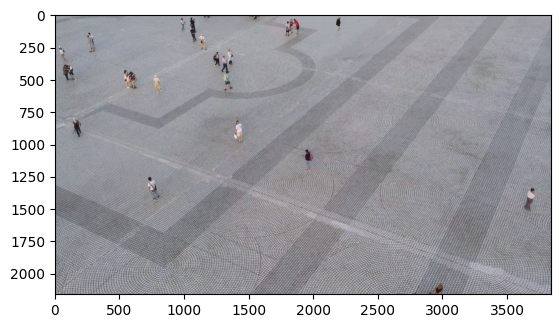

In [ ]:
# Verificando uma imagem
test_file = TRAIN_DATA_DIR + '/Drone_049/vott-csv-export/Drone_049.mp4_t-9.jpg' 

img = cv2.imread(test_file)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

##Analisando dados de treino

In [ ]:
#Montar tabela com todos os dados de treino ou teste
def dataframe(DATA_DIR):
  pastas = os.listdir(DATA_DIR) 

  data = []
  #count = 0
  for dir in pastas:
      export_path = os.path.join(DATA_DIR, dir, 'vott-csv-export')
      label_file = export_path + '/' + dir + '-export.csv'
      df = pd.read_csv(label_file)
      data.append(df)
  return data, pastas

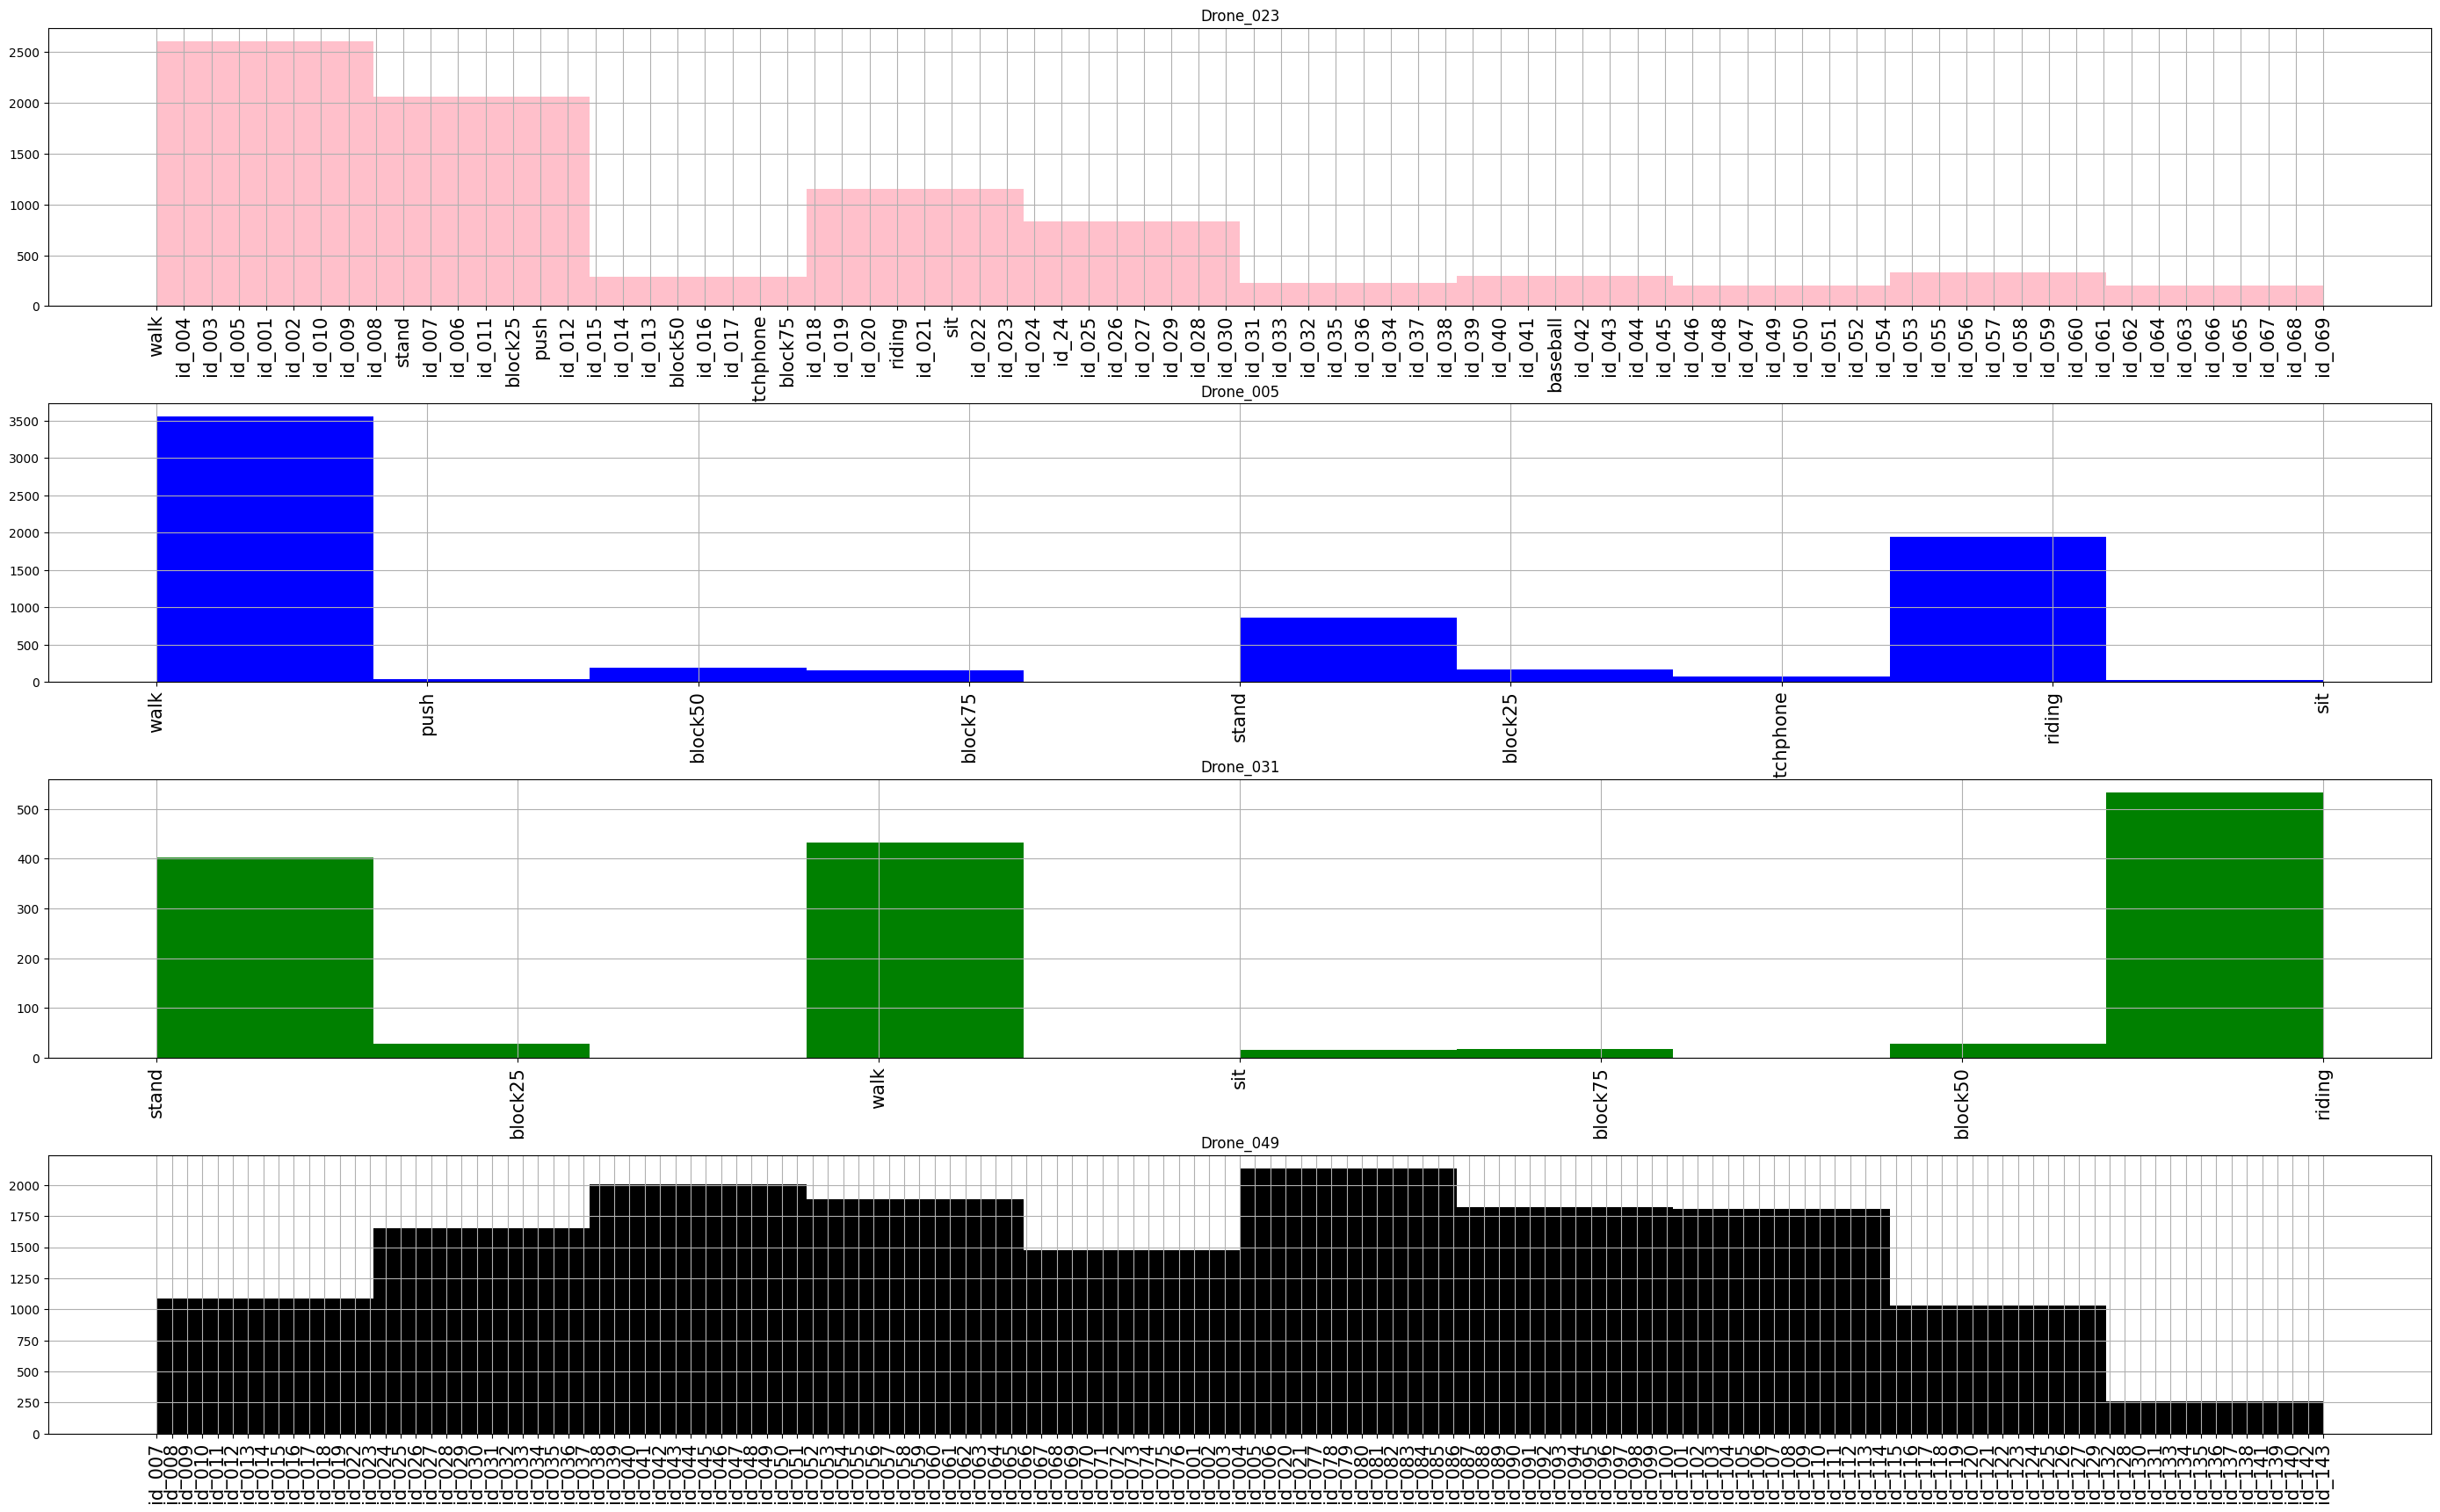

In [ ]:
data, pastas = dataframe(TRAIN_DATA_DIR)  #chama função para montar dataframe de cada pasta

#plota o histograma
figura = plt.figure(figsize=(35,20))
color = ['pink','blue','green','black']

for c in range(len(pastas)):
  a = figura.add_subplot(4,1,c+1)
  a.title.set_text(pastas[c])
  plt.hist(data[c]['label'], rwidth=1, color = color[c])
  plt.xticks(rotation=90,fontsize=15)
  plt.grid()
  plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)

##Analisando os dados de teste

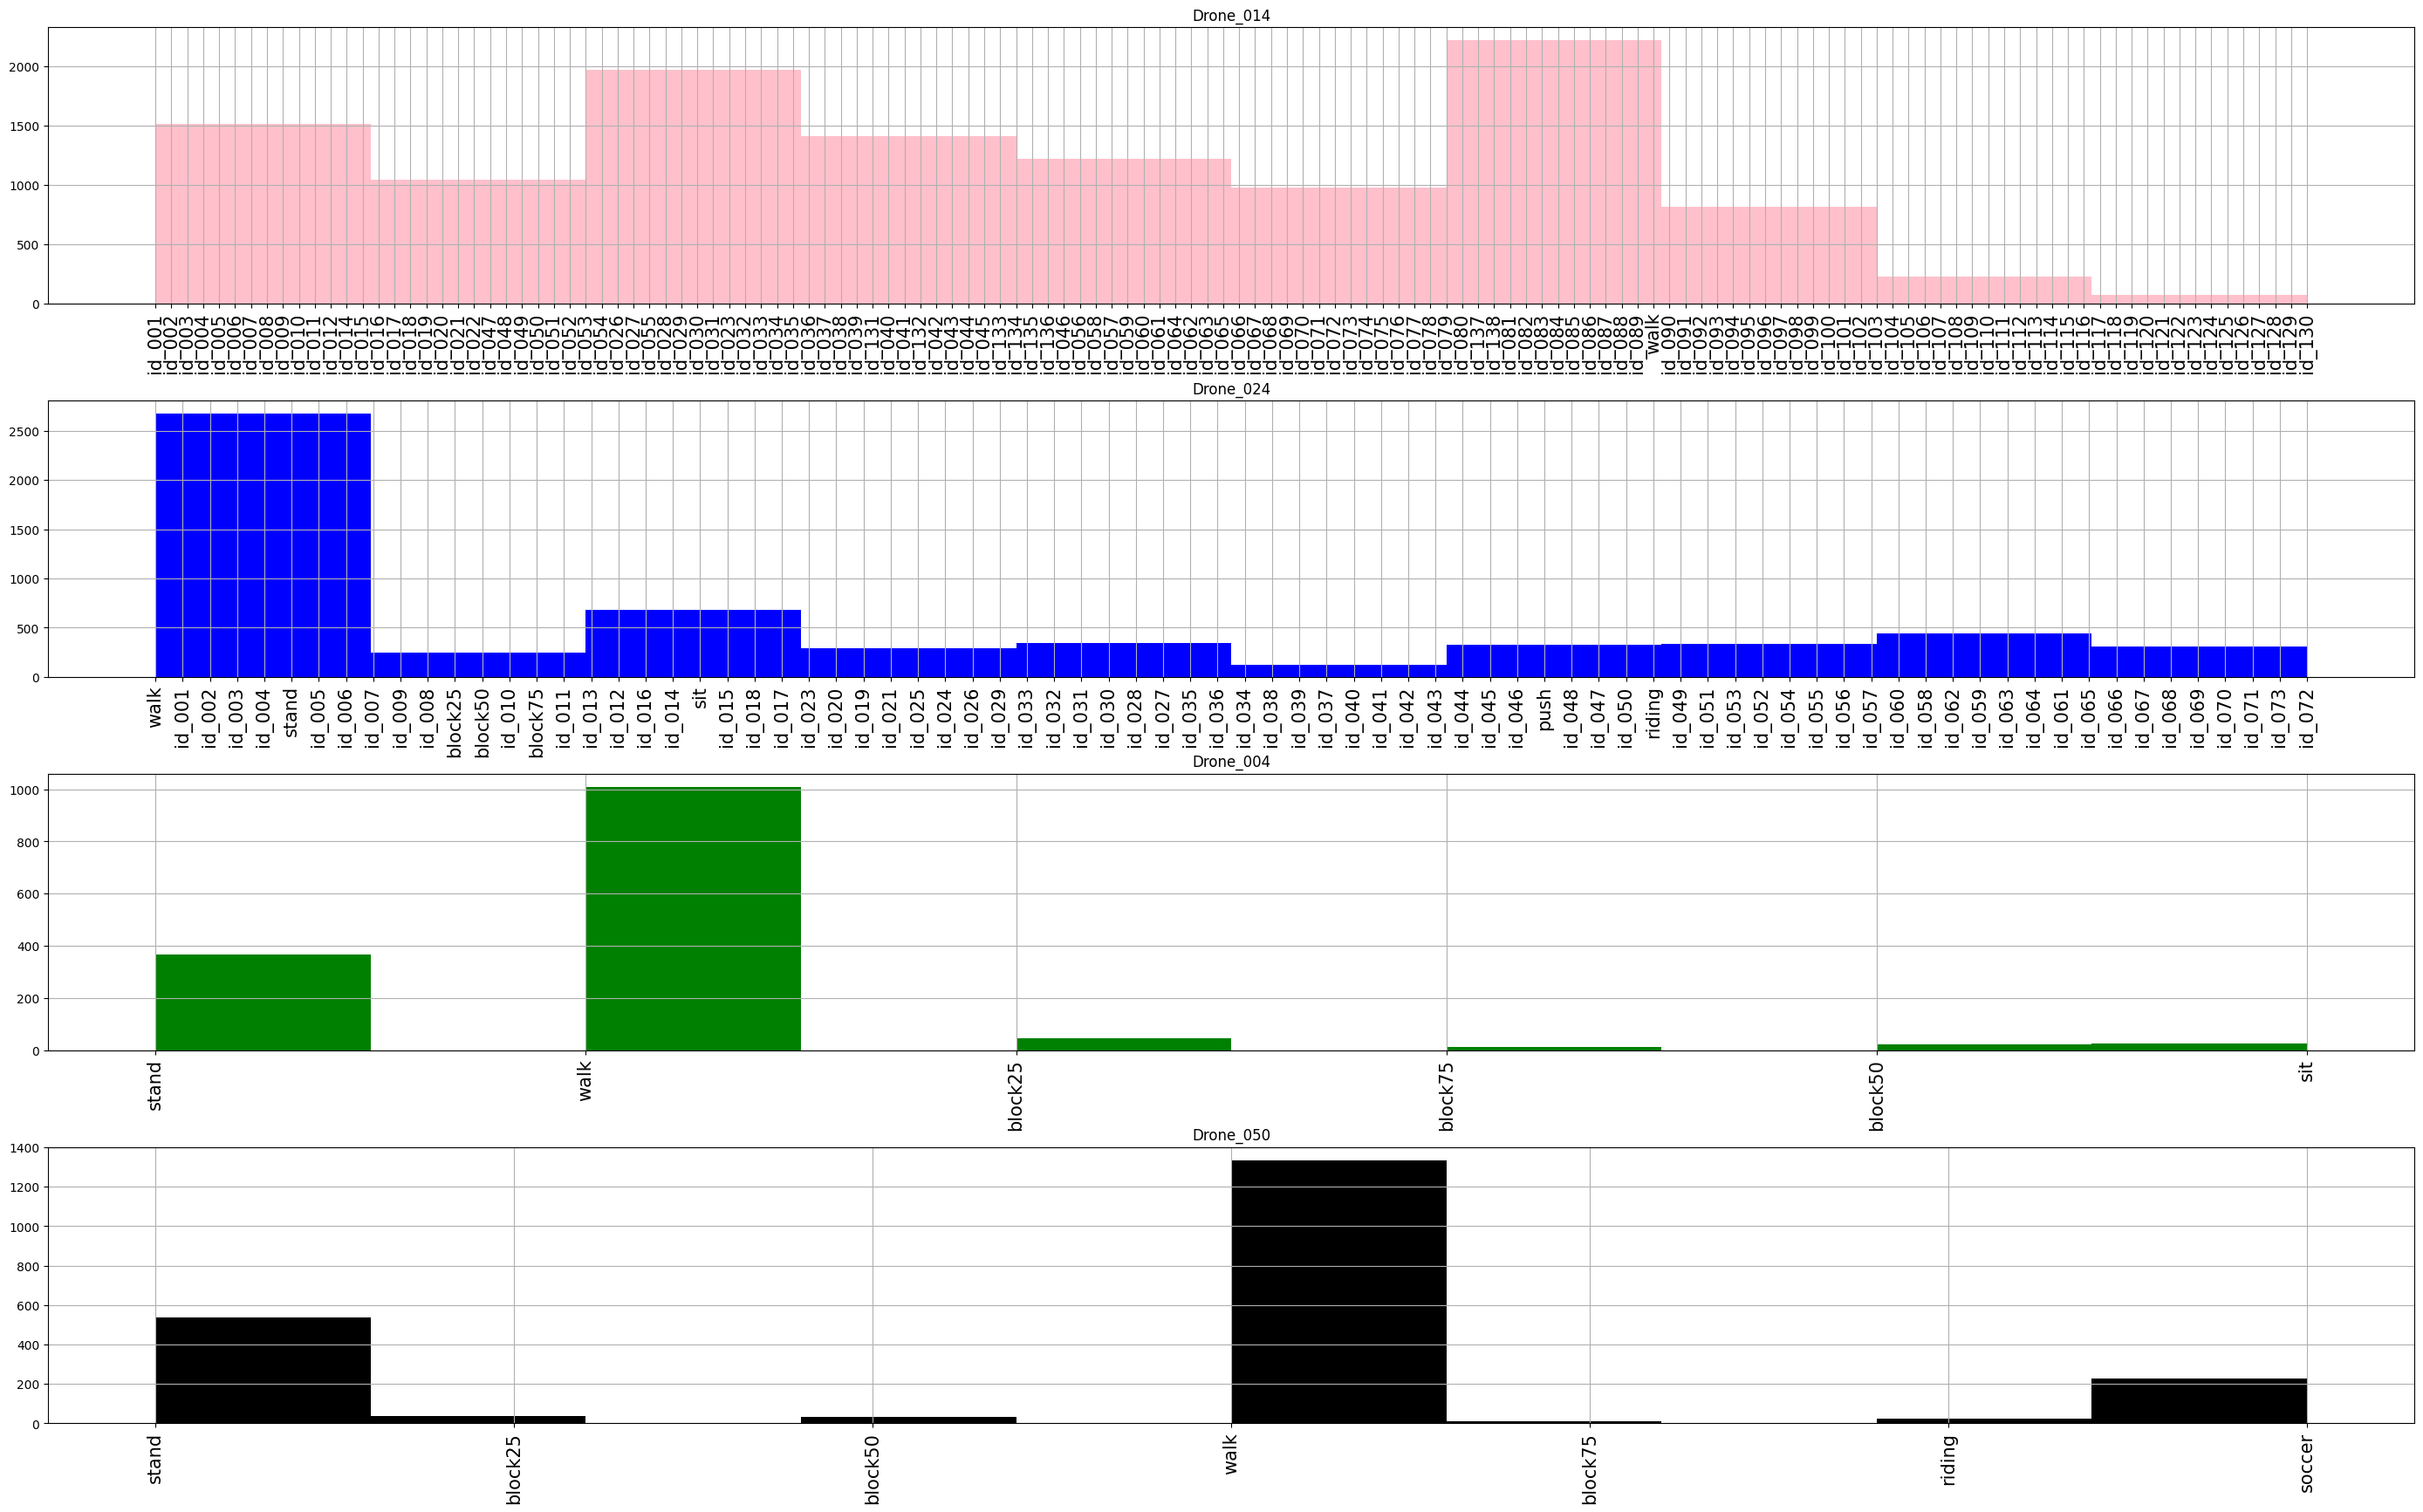

In [ ]:
data, pastas = dataframe(TEST_DATA_DIR)   #chama função para montar dataframe de cada pasta

#plota o histograma
figura = plt.figure(figsize=(35,20))
color = ['pink','blue','green','black']

for c in range(len(pastas)):
  a = figura.add_subplot(4,1,c+1)
  a.title.set_text(pastas[c])
  plt.hist(data[c]['label'], rwidth=1, color = color[c])
  plt.xticks(rotation=90,fontsize=15)
  plt.grid()
  plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)

##Agrupando pastas e selecionando algumas classes

###Juntando dados de treino

In [ ]:
#Montar tabela com todos os dados de treino ou teste
def data(DATA_DIR):
  pastas = os.listdir(DATA_DIR) 

  data = []
  count = 0
  for dir in pastas:
      export_path = os.path.join(DATA_DIR, dir, 'vott-csv-export')
      label_file = export_path + '/' + dir + '-export.csv'
      df = pd.read_csv(label_file)
      if count == 0:
        df_inicial = df
      else:
        df_inicial = pd.merge(df_inicial, df, how = 'outer')
      count +=1
  return df_inicial

###Colocando .jpg em cada um dos nomes das imagens

In [ ]:
def renomeia_jpg(dataframe):

  lista_nomeia = list(dataframe.iloc[:,0])
  renomeacao_imagem = []

  for imagem in lista_nomeia:
    if not imagem.endswith('.jpg'):
      imagem = imagem + ".jpg"
    renomeacao_imagem.append(imagem)
  
  dataframe.drop("image",axis=1,inplace=True)
  dataframe.insert(0,"image", renomeacao_imagem,True)
  return dataframe


In [ ]:
data_train = data(TRAIN_DATA_DIR)           #chama função para montar dataframe de cada pasta
data_train = renomeia_jpg(data_train)       #coloca .jpg no nome de todas as imagens
data_train

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.jpg,703.955892,1294.659926,780.702963,1371.424632,walk
1,Drone_023.mp4_t-0.jpg,703.955892,1294.659926,780.702963,1371.424632,id_004
2,Drone_023.mp4_t-0.jpg,632.501723,1215.248162,725.127498,1302.601103,walk
3,Drone_023.mp4_t-0.jpg,632.501723,1215.248162,725.127498,1302.601103,id_003
4,Drone_023.mp4_t-0.jpg,1143.266713,1239.071691,1227.953136,1329.071691,walk
...,...,...,...,...,...,...
31800,Drone_049.mp4_t-97.jpg,2269.987061,97.393196,2302.460018,155.844521,id_140
31801,Drone_049.mp4_t-97.jpg,2438.523926,974.331116,2471.163925,1105.911118,id_142
31802,Drone_049.mp4_t-97.jpg,2498.020264,999.278198,2531.020260,1088.278191,id_143
31803,Drone_049.mp4_t-97.jpg,3624.549805,701.250793,3659.229805,815.490791,id_105


###Filtrando dados de treino

In [ ]:
lista = ['walk', 'stand', 'sit', 'riding']
remover_classes = []
for c in range(len(data_train)):
  if not data_train.iloc[c,5] in lista:
    remover_classes.append(c)

data_train_filtrado = data_train.drop(remover_classes, axis='index') 
data_train_filtrado

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.jpg,703.955892,1294.659926,780.702963,1371.424632,walk
2,Drone_023.mp4_t-0.jpg,632.501723,1215.248162,725.127498,1302.601103,walk
4,Drone_023.mp4_t-0.jpg,1143.266713,1239.071691,1227.953136,1329.071691,walk
6,Drone_023.mp4_t-0.jpg,613.976568,1442.895221,696.016540,1511.718750,walk
8,Drone_023.mp4_t-0.jpg,574.279807,1405.836397,637.794624,1466.718750,walk
...,...,...,...,...,...,...
16650,Drone_031.mp4_t-520.333333.jpg,2207.550228,1985.400055,2268.011290,2054.520099,stand
16651,Drone_031.mp4_t-520.333333.jpg,2273.769403,2034.359967,2345.746910,2106.359967,stand
16652,Drone_031.mp4_t-520.5.jpg,2138.451778,2068.920099,2173.000893,2160.000000,stand
16653,Drone_031.mp4_t-520.5.jpg,2302.560406,2068.920099,2357.263355,2143.800055,stand


##Validação

In [ ]:
#Separar dados de validação (20%) e treino (80%)
x = data_train_filtrado.iloc[:,0]
y = data_train_filtrado.iloc[:,1:]

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

##Juntando dados de teste

In [ ]:
data_test = data(TEST_DATA_DIR)
data_test = renomeia_jpg(data_test)
data_test

,image,xmin,ymin,xmax,ymax,label
0,Drone_014.mp4_t-0.jpg,1717.546520,0.000000,2278.594073,1410.882353,id_001
1,Drone_014.mp4_t-0.jpg,3516.101218,1011.600000,3627.666354,1245.600000,id_002
2,Drone_014.mp4_t-0.jpg,1540.318650,1087.200000,1605.098407,1281.600000,id_003
3,Drone_014.mp4_t-0.jpg,1432.352390,1047.600000,1497.132146,1303.200000,id_004
4,Drone_014.mp4_t-0.jpg,1356.776007,1055.895221,1425.154639,1292.400000,id_005
...,...,...,...,...,...,...
20915,Drone_050.mp4_t-116.166667.jpg,3000.714618,1345.079460,3032.994746,1420.443925,walk
20916,Drone_050.mp4_t-116.jpg,2998.024436,1345.079460,3035.684928,1415.060830,walk
20917,Drone_050.mp4_t-115.833333.jpg,2998.024436,1353.154206,3032.994746,1417.752378,walk
20918,Drone_050.mp4_t-115.666667.jpg,3006.094571,1345.079460,3030.304975,1417.752378,walk


###Filtrando dados de teste

In [ ]:
lista = ['walk', 'stand', 'sit', 'riding']
remover_classes = []
for c in range(len(data_test)):
  if not data_test.iloc[c,5] in lista:
    remover_classes.append(c)

data_test_filtrado = data_test.drop(remover_classes, axis='index') 
data_test_filtrado

,image,xmin,ymin,xmax,ymax,label
7496,Drone_014.mp4_t-92.833333.jpg,2353.979980,1031.943604,2455.979980,1432.803589,walk
7498,Drone_014.mp4_t-92.833333.jpg,2176.063965,1082.634033,2273.695068,1400.996338,walk
7500,Drone_014.mp4_t-92.833333.jpg,2988.754395,924.187073,3031.891628,1062.422302,walk
7502,Drone_014.mp4_t-92.833333.jpg,2016.704224,983.228149,2033.178566,1049.125519,walk
7504,Drone_014.mp4_t-92.833333.jpg,2875.814941,925.881409,2911.138443,1025.511803,walk
...,...,...,...,...,...,...
20915,Drone_050.mp4_t-116.166667.jpg,3000.714618,1345.079460,3032.994746,1420.443925,walk
20916,Drone_050.mp4_t-116.jpg,2998.024436,1345.079460,3035.684928,1415.060830,walk
20917,Drone_050.mp4_t-115.833333.jpg,2998.024436,1353.154206,3032.994746,1417.752378,walk
20918,Drone_050.mp4_t-115.666667.jpg,3006.094571,1345.079460,3030.304975,1417.752378,walk


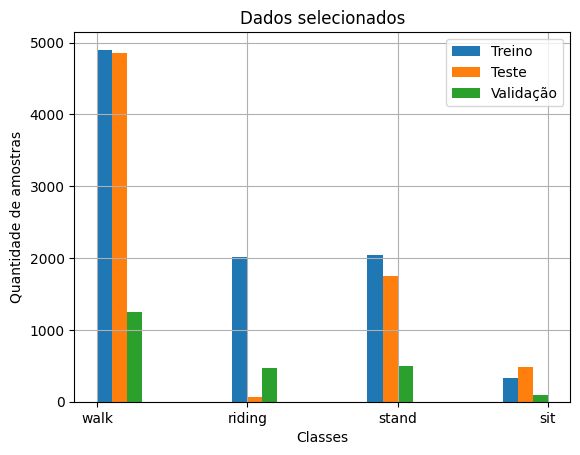

In [ ]:
#plota o histograma
plt.title("Dados selecionados")
plt.hist([y_train['label'],data_test_filtrado['label'],y_val['label']], rwidth=1, label=['Treino', 'Teste', 'Validação' ])
plt.xlabel("Classes")
plt.ylabel("Quantidade de amostras")
plt.legend()
plt.grid()

## Salvando os dados

In [ ]:
#Salva todas as imagens selecionadas 
def salva_dados_selecionados(dado, DATA_DIR, path_saida):
  imagem_nao_existe = []
  for imagem in tqdm(dado):
    files = DATA_DIR + '/' + imagem[:9] +'/vott-csv-export/' + imagem
    if os.path.isfile(files):                           #verifica se a iamgem está dentro da pasta
      shutil.copy(files,path_saida)                   #copia imagem para a nova pasta
    else:
      imagem_nao_existe.append(imagem)
  return imagem_nao_existe

###Treino

In [ ]:
path_treino = '/content/gdrive/My Drive/IA901_Projeto/Dados_filtrados/Treino/images'

X_train = list(X_train)
imagem_nao_existe = salva_dados_selecionados(X_train, TRAIN_DATA_DIR, path_treino)
print(imagem_nao_existe)

100%|██████████| 9293/9293 [00:02<00:00, 3703.24it/s]

['Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-158.jpg', 'Drone_005.mp4_t-158.5.jpg', 'Drone_005.mp4_t-158.jpg', 'Drone_031.mp4_t-498.666667.jpg', 'Drone_005.mp4_t-159.jpg', 'Drone_005.mp4_t-160.5.jpg', 'Drone_005.mp4_t-179.666667.jpg', 'Drone_005.mp4_t-156.666667.jpg', 'Drone_031.mp4_t-510.333333.jpg', 'Drone_005.mp4_t-159.5.jpg', 'Drone_031.mp4_t-508.666667.jpg', 'Drone_005.mp4_t-183.833333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-159.jpg', 'Drone_031.mp4_t-514.5.jpg', 'Drone_005.mp4_t-178.833333.jpg', 'Drone_005.mp4_t-156.333333.jpg', 'Drone_031.mp4_t-508.166667.jpg', 'Drone_031.mp4_t-510.333333.jpg', 'Drone_005.mp4_t-157.5.jpg', 'Drone_031.mp4_t-509.333333.jpg', 'Drone_005.mp4_t-158.jpg', 'Drone_005.mp4_t-162.jpg', 'Drone_005.mp4_t-181.833333.jpg', 'Drone_031.mp4_t-499.jpg', 'Drone_031.mp4_t-495.166667.jpg', 'Drone_005.mp4_t-182.166667.jpg', 'Drone_005.mp4_t-156.833333.jpg', 'Drone_031.mp4_t-516.333333.jpg', 'Drone_005.mp4_t-159.jpg', 'Drone_031.mp4_t-514.33333

####Monta csv

In [ ]:
#adiciona a coluna "image" no y_train
y_train.insert(0,"image", X_train,True)
y_train

,image,xmin,ymin,xmax,ymax,label
7461,Drone_023.mp4_t-88.jpg,2432.088215,685.836397,2474.431427,749.365809,walk
14536,Drone_005.mp4_t-155.333333.jpg,1109.445910,626.412661,1167.704485,702.379836,walk
10769,Drone_005.mp4_t-95.666667.jpg,221.441678,1636.835664,312.031455,1717.395105,walk
14864,Drone_005.mp4_t-158.jpg,2023.852243,1375.955451,2079.577836,1456.987104,walk
13898,Drone_005.mp4_t-148.666667.jpg,3320.738786,970.797186,3437.255937,1115.134818,riding
...,...,...,...,...,...,...
12560,Drone_005.mp4_t-106.166667.jpg,711.767810,717.573271,777.625330,796.072685,walk
15981,Drone_031.mp4_t-289.jpg,3396.618732,2089.080011,3477.233628,2160.000000,riding
1971,Drone_023.mp4_t-20.833333.jpg,1812.818746,1683.777574,1900.151620,1800.248162,walk
9758,Drone_005.mp4_t-90.333333.jpg,3490.222805,237.115385,3590.878113,393.199301,riding


In [ ]:
#Reorganiza os indices do dataframe
y_train = y_train.reset_index(drop=True)
y_train

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-88.jpg,2432.088215,685.836397,2474.431427,749.365809,walk
1,Drone_005.mp4_t-155.333333.jpg,1109.445910,626.412661,1167.704485,702.379836,walk
2,Drone_005.mp4_t-95.666667.jpg,221.441678,1636.835664,312.031455,1717.395105,walk
3,Drone_005.mp4_t-158.jpg,2023.852243,1375.955451,2079.577836,1456.987104,walk
4,Drone_005.mp4_t-148.666667.jpg,3320.738786,970.797186,3437.255937,1115.134818,riding
...,...,...,...,...,...,...
9288,Drone_005.mp4_t-106.166667.jpg,711.767810,717.573271,777.625330,796.072685,walk
9289,Drone_031.mp4_t-289.jpg,3396.618732,2089.080011,3477.233628,2160.000000,riding
9290,Drone_023.mp4_t-20.833333.jpg,1812.818746,1683.777574,1900.151620,1800.248162,walk
9291,Drone_005.mp4_t-90.333333.jpg,3490.222805,237.115385,3590.878113,393.199301,riding


In [ ]:
#antes de montar o dataframe tira imagens que estavam no csv dataframe original
#mas não estavam de fato na pasta dos dados originais
remover_classes = []
for c in range(len(X_train)):
  if y_train.iloc[c,0] in imagem_nao_existe:
    remover_classes.append(c)

y_train.drop(remover_classes, inplace=True) 
#y_train.to_csv('label_train',index=False)
y_train

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-88.jpg,2432.088215,685.836397,2474.431427,749.365809,walk
2,Drone_005.mp4_t-95.666667.jpg,221.441678,1636.835664,312.031455,1717.395105,walk
4,Drone_005.mp4_t-148.666667.jpg,3320.738786,970.797186,3437.255937,1115.134818,riding
5,Drone_005.mp4_t-58.5.jpg,2921.912682,1185.988300,3007.068607,1308.352833,walk
6,Drone_023.mp4_t-61.833333.jpg,1720.192970,2107.058824,1794.293591,2160.000000,stand
...,...,...,...,...,...,...
9288,Drone_005.mp4_t-106.166667.jpg,711.767810,717.573271,777.625330,796.072685,walk
9289,Drone_031.mp4_t-289.jpg,3396.618732,2089.080011,3477.233628,2160.000000,riding
9290,Drone_023.mp4_t-20.833333.jpg,1812.818746,1683.777574,1900.151620,1800.248162,walk
9291,Drone_005.mp4_t-90.333333.jpg,3490.222805,237.115385,3590.878113,393.199301,riding


##Teste

In [ ]:
path_test = '/content/gdrive/My Drive/IA901_Projeto/Dados_filtrados/Teste/images'

X_teste = list(data_test_filtrado.iloc[:,0])
imagem_nao_existe1 = salva_dados_selecionados(X_teste, TEST_DATA_DIR, path_test)
print(imagem_nao_existe1)

100%|██████████| 7163/7163 [00:01<00:00, 4274.54it/s]

['Drone_050.mp4_t-162.5.jpg', 'Drone_050.mp4_t-162.5.jpg', 'Drone_050.mp4_t-162.5.jpg', 'Drone_050.mp4_t-162.5.jpg', 'Drone_050.mp4_t-162.666667.jpg', 'Drone_050.mp4_t-162.666667.jpg', 'Drone_050.mp4_t-162.666667.jpg', 'Drone_050.mp4_t-162.666667.jpg', 'Drone_050.mp4_t-162.833333.jpg', 'Drone_050.mp4_t-162.833333.jpg', 'Drone_050.mp4_t-162.833333.jpg', 'Drone_050.mp4_t-162.833333.jpg', 'Drone_050.mp4_t-163.jpg', 'Drone_050.mp4_t-163.jpg', 'Drone_050.mp4_t-163.jpg', 'Drone_050.mp4_t-163.jpg', 'Drone_050.mp4_t-163.166667.jpg', 'Drone_050.mp4_t-163.166667.jpg', 'Drone_050.mp4_t-163.166667.jpg', 'Drone_050.mp4_t-163.333333.jpg', 'Drone_050.mp4_t-163.333333.jpg', 'Drone_050.mp4_t-163.333333.jpg', 'Drone_050.mp4_t-163.5.jpg', 'Drone_050.mp4_t-163.5.jpg', 'Drone_050.mp4_t-163.5.jpg', 'Drone_050.mp4_t-163.5.jpg', 'Drone_050.mp4_t-163.666667.jpg', 'Drone_050.mp4_t-163.666667.jpg', 'Drone_050.mp4_t-163.666667.jpg', 'Drone_050.mp4_t-163.666667.jpg', 'Drone_050.mp4_t-163.833333.jpg', 'Drone_050.mp

###Monta csv

In [ ]:
#Reorganiza os indices do dataframe
data_test_filtrado = data_test_filtrado.reset_index(drop=True)
data_test_filtrado

,image,xmin,ymin,xmax,ymax,label
0,Drone_014.mp4_t-92.833333.jpg,2353.979980,1031.943604,2455.979980,1432.803589,walk
1,Drone_014.mp4_t-92.833333.jpg,2176.063965,1082.634033,2273.695068,1400.996338,walk
2,Drone_014.mp4_t-92.833333.jpg,2988.754395,924.187073,3031.891628,1062.422302,walk
3,Drone_014.mp4_t-92.833333.jpg,2016.704224,983.228149,2033.178566,1049.125519,walk
4,Drone_014.mp4_t-92.833333.jpg,2875.814941,925.881409,2911.138443,1025.511803,walk
...,...,...,...,...,...,...
7158,Drone_050.mp4_t-116.166667.jpg,3000.714618,1345.079460,3032.994746,1420.443925,walk
7159,Drone_050.mp4_t-116.jpg,2998.024436,1345.079460,3035.684928,1415.060830,walk
7160,Drone_050.mp4_t-115.833333.jpg,2998.024436,1353.154206,3032.994746,1417.752378,walk
7161,Drone_050.mp4_t-115.666667.jpg,3006.094571,1345.079460,3030.304975,1417.752378,walk


In [ ]:
#antes de montar o dataframe tira imagens que estavam no csv dataframe original
#mas não estavam de fato na pasta dos dados originais
remover_classes = []
for c in range(len(data_test_filtrado)):
  if data_test_filtrado.iloc[c,0] in imagem_nao_existe1:
    remover_classes.append(c)

data_test_filtrado.drop(remover_classes, inplace=True) 
#data_test_filtrado.to_csv('label_test',index=False)
data_test_filtrado

,image,xmin,ymin,xmax,ymax,label
0,Drone_014.mp4_t-92.833333.jpg,2353.979980,1031.943604,2455.979980,1432.803589,walk
1,Drone_014.mp4_t-92.833333.jpg,2176.063965,1082.634033,2273.695068,1400.996338,walk
2,Drone_014.mp4_t-92.833333.jpg,2988.754395,924.187073,3031.891628,1062.422302,walk
3,Drone_014.mp4_t-92.833333.jpg,2016.704224,983.228149,2033.178566,1049.125519,walk
4,Drone_014.mp4_t-92.833333.jpg,2875.814941,925.881409,2911.138443,1025.511803,walk
...,...,...,...,...,...,...
6266,Drone_050.mp4_t-162.166667.jpg,3092.175049,1310.088826,3132.525312,1388.144942,walk
6267,Drone_050.mp4_t-162.333333.jpg,3474.285714,1413.885430,3536.134454,1524.171856,walk
6268,Drone_050.mp4_t-162.333333.jpg,2137.815126,1526.861768,2186.218487,1642.528020,walk
6269,Drone_050.mp4_t-162.333333.jpg,2172.773109,1524.171856,2218.487395,1623.698630,walk


##Validação

In [ ]:
path_val = '/content/gdrive/My Drive/IA901_Projeto/Dados_filtrados/Val/images'

X_val = list(X_val)
imagem_nao_existe2 = salva_dados_selecionados(X_val, TRAIN_DATA_DIR, path_val)
print(imagem_nao_existe2)

100%|██████████| 2324/2324 [00:00<00:00, 3758.07it/s]

['Drone_005.mp4_t-158.5.jpg', 'Drone_031.mp4_t-509.666667.jpg', 'Drone_031.mp4_t-510.333333.jpg', 'Drone_005.mp4_t-157.5.jpg', 'Drone_031.mp4_t-518.jpg', 'Drone_031.mp4_t-507.5.jpg', 'Drone_005.mp4_t-156.666667.jpg', 'Drone_031.mp4_t-510.5.jpg', 'Drone_031.mp4_t-491.166667.jpg', 'Drone_005.mp4_t-181.166667.jpg', 'Drone_005.mp4_t-160.666667.jpg', 'Drone_031.mp4_t-499.5.jpg', 'Drone_005.mp4_t-157.333333.jpg', 'Drone_031.mp4_t-512.5.jpg', 'Drone_005.mp4_t-157.833333.jpg', 'Drone_005.mp4_t-157.166667.jpg', 'Drone_005.mp4_t-157.833333.jpg', 'Drone_005.mp4_t-163.jpg', 'Drone_031.mp4_t-517.5.jpg', 'Drone_005.mp4_t-164.166667.jpg', 'Drone_031.mp4_t-517.333333.jpg', 'Drone_031.mp4_t-515.333333.jpg', 'Drone_005.mp4_t-159.166667.jpg', 'Drone_005.mp4_t-159.666667.jpg', 'Drone_005.mp4_t-157.666667.jpg', 'Drone_005.mp4_t-155.833333.jpg', 'Drone_005.mp4_t-155.833333.jpg', 'Drone_005.mp4_t-157.833333.jpg', 'Drone_005.mp4_t-159.833333.jpg', 'Drone_005.mp4_t-163.333333.jpg', 'Drone_005.mp4_t-156.666667.

###Monta csv

In [ ]:
#adiciona a coluna "image" no y_val
y_val.insert(0,"image", X_val,True)
y_val 

,image,xmin,ymin,xmax,ymax,label
14906,Drone_005.mp4_t-158.5.jpg,3677.889182,717.573271,3819.736148,877.104338,riding
1626,Drone_023.mp4_t-16.166667.jpg,95.272226,884.365809,219.655410,1014.071691,walk
12825,Drone_005.mp4_t-107.666667.jpg,871.345646,2039.402110,967.598945,2117.901524,walk
16479,Drone_031.mp4_t-509.666667.jpg,1565.510778,225.719989,1585.664612,286.200000,stand
2481,Drone_023.mp4_t-27.333333.jpg,1489.951757,1757.895221,1590.516885,1861.130515,walk
...,...,...,...,...,...,...
7161,Drone_023.mp4_t-84.5.jpg,1439.669194,8.189338,1505.830462,122.012868,walk
903,Drone_023.mp4_t-8.jpg,2103.928325,1429.659926,2162.150241,1527.601103,walk
454,Drone_023.mp4_t-4.jpg,1434.376292,1448.189338,1513.769814,1501.130515,walk
15403,Drone_031.mp4_t-31.166667.jpg,2782.483070,542.981928,2860.496614,664.427711,stand


In [ ]:
#Reorganiza os indices do dataframe
y_val = y_val.reset_index(drop=True)
y_val

,image,xmin,ymin,xmax,ymax,label
0,Drone_005.mp4_t-158.5.jpg,3677.889182,717.573271,3819.736148,877.104338,riding
1,Drone_023.mp4_t-16.166667.jpg,95.272226,884.365809,219.655410,1014.071691,walk
2,Drone_005.mp4_t-107.666667.jpg,871.345646,2039.402110,967.598945,2117.901524,walk
3,Drone_031.mp4_t-509.666667.jpg,1565.510778,225.719989,1585.664612,286.200000,stand
4,Drone_023.mp4_t-27.333333.jpg,1489.951757,1757.895221,1590.516885,1861.130515,walk
...,...,...,...,...,...,...
2319,Drone_023.mp4_t-84.5.jpg,1439.669194,8.189338,1505.830462,122.012868,walk
2320,Drone_023.mp4_t-8.jpg,2103.928325,1429.659926,2162.150241,1527.601103,walk
2321,Drone_023.mp4_t-4.jpg,1434.376292,1448.189338,1513.769814,1501.130515,walk
2322,Drone_031.mp4_t-31.166667.jpg,2782.483070,542.981928,2860.496614,664.427711,stand


In [ ]:
#antes de montar o dataframe tira imagens que estavam no csv dataframe original
#mas não estavam de fato na pasta dos dados originais
remover_classes = []
for c in range(len(X_val)):
  if y_val.iloc[c,0] in imagem_nao_existe2:
    remover_classes.append(c)

y_val.drop(remover_classes, inplace=True) 
#y_val.to_csv('label_val',index=False)
y_val

,image,xmin,ymin,xmax,ymax,label
1,Drone_023.mp4_t-16.166667.jpg,95.272226,884.365809,219.655410,1014.071691,walk
2,Drone_005.mp4_t-107.666667.jpg,871.345646,2039.402110,967.598945,2117.901524,walk
4,Drone_023.mp4_t-27.333333.jpg,1489.951757,1757.895221,1590.516885,1861.130515,walk
5,Drone_005.mp4_t-153.333333.jpg,1170.237467,687.186401,1246.226913,753.024619,walk
6,Drone_005.mp4_t-54.666667.jpg,2687.733888,1447.093596,2754.261954,1564.137931,walk
...,...,...,...,...,...,...
2319,Drone_023.mp4_t-84.5.jpg,1439.669194,8.189338,1505.830462,122.012868,walk
2320,Drone_023.mp4_t-8.jpg,2103.928325,1429.659926,2162.150241,1527.601103,walk
2321,Drone_023.mp4_t-4.jpg,1434.376292,1448.189338,1513.769814,1501.130515,walk
2322,Drone_031.mp4_t-31.166667.jpg,2782.483070,542.981928,2860.496614,664.427711,stand


##Quantidade de imagens

In [ ]:
#Treino
qtd_treino = os.listdir(path_treino) 
qtd_teste = os.listdir(path_test)
qtd_val = os.listdir(path_val)  

print("Treino = ", len(qtd_treino))
print("Teste = ", len(qtd_teste))
print("Val = ", len(qtd_val))

Treino =  1677
Teste =  1266
Val =  1006


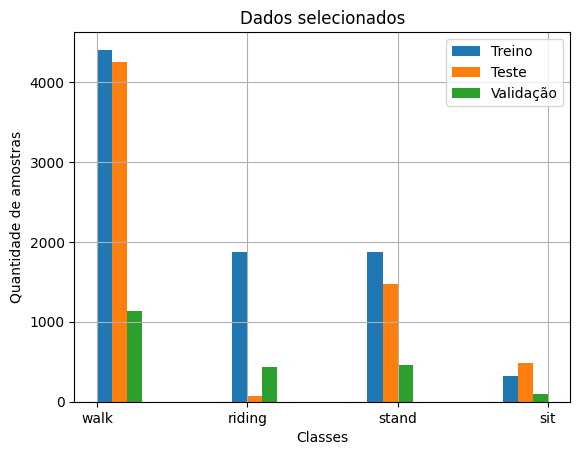

In [ ]:
#plota o histograma --> quantidade de amostras que de fato serão utilizadas
plt.title("Dados selecionados")
plt.hist([y_train['label'],data_test_filtrado['label'],y_val['label']], rwidth=1, label=['Treino', 'Teste', 'Validação' ])
plt.xlabel("Classes")
plt.ylabel("Quantidade de amostras")
plt.legend()
plt.grid()